## RNN   
2023 / 04/09   
1602i  
I feel a little sick  
lets get init  


In [82]:
##Hardware
import torch
if torch.cuda.is_available() == True:
    device = 'cuda'
    templist = [1,2,3]
    templist = torch.FloatTensor(templist).to(device)
    print("Cuda torch working : ",end="")
    print(templist.is_cuda)
    print("current device no. : ",end="")
    print(torch.cuda.current_device())
    print("GPU device count : ",end="")
    print(torch.cuda.device_count())
    print("GPU name : ",end="")
    print(torch.cuda.get_device_name(0))
    print("device : ",device)
    ! nvidia-smi
elif torch.backends.mps.is_available() == True:
    print("Apple device detected\nActivating Apple Silicon GPU")
    device = torch.device("mps")
else:
    print("cant use gpu , activating cpu")
    device = 'cpu'

Apple device detected
Activating Apple Silicon GPU


In [83]:
#not test
batch_size = 128
max_epochs = 30
learning_rate = 3e-5
hidden_sizes = [100, 100] # hidden_sizes must be a list

### Using 9 figurs from the data and making it as a list

In [84]:
import numpy as np
import csv

def preprocess(all_files):
    data_0 = []  # 기온
    data_1 = []  # 강수량
    data_2 = []  # 풍속
    data_3 = []  # 습도
    data_4 = []  # 증기압
    data_5 = []  # 이슬점 온도
    data_6 = []  # 현지 기압
    data_7 = []  # 해면 기압
    data_8 = []  # 지면 온도
    for f in all_files:
        with open(f, encoding='euc-kr') as c:
            csv_reader = csv.reader(c, delimiter=',')
            header = True
            for col in csv_reader:
                if header:
                    header = False
                    continue
                data_0.append(
                    float(col[2])) if col[2] != '' else data_0.append(0.0)
                data_1.append(
                    float(col[3])) if col[3] != '' else data_1.append(0.0)
                data_2.append(
                    float(col[4])) if col[4] != '' else data_2.append(0.0)
                data_3.append(
                    float(col[6])) if col[6] != '' else data_3.append(0.0)
                data_4.append(
                    float(col[7])) if col[7] != '' else data_4.append(0.0)
                data_5.append(
                    float(col[8])) if col[8] != '' else data_5.append(0.0)
                data_6.append(
                    float(col[9])) if col[9] != '' else data_6.append(0.0)
                data_7.append(
                    float(col[10])) if col[10] != '' else data_7.append(0.0)
                data_8.append(
                    float(col[22])) if col[22] != '' else data_8.append(0.0)

    data = np.zeros((len(data_0), 9))
    for i, d in enumerate(data):
        data[i, 0] = data_0[i]
        data[i, 1] = data_1[i]
        data[i, 2] = data_2[i]
        data[i, 3] = data_3[i]
        data[i, 4] = data_4[i]
        data[i, 5] = data_5[i]
        data[i, 6] = data_6[i]
        data[i, 7] = data_7[i]
        data[i, 8] = data_8[i]

    return data.astype(np.float32)

In [85]:
# Make data
import glob
import os

data_dir = './data/climate_seoul'

train_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'train', '*'))))
val_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'val', '*'))))
test_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'test', '*'))))

In [86]:
#Len Data
print(len(train_data))
print(len(val_data))
print(len(test_data))

70133
8760
8760


In [87]:
## Shape
print("shape of train data: {}".format(train_data.shape))
print("shape of val data: {}".format(val_data.shape))
print("shape of test data: {}".format(test_data.shape))

shape of train data: (70133, 9)
shape of val data: (8760, 9)
shape of test data: (8760, 9)


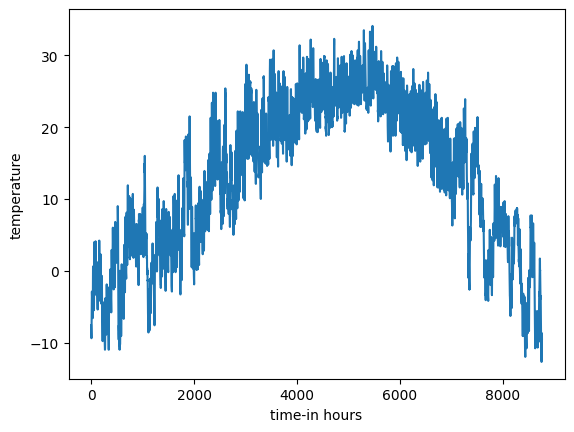

In [88]:
## Data visualization
import matplotlib.pyplot as plt

start = 0
dt = 8760 # this is hours 365 * 24 = 8760
plt.plot(train_data[start:start+dt, 0])
plt.ylabel("temperature")
plt.xlabel("time-in hours")
plt.show()

## explain  

data = dataset (n,9)  
seq_length = data len of before  
target_delay = data target after this much of time  
strides = how many skips in every data  


In [89]:
def make_dataset(data, seq_length=480, target_delay=24, strides=5,
                 mode='train', train_mean=None, train_std=None):
    '''
        각 인수에 대한 설명은 위의 'Dataset만들기' 설명을 참고하세요.
    '''
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    
    if mode is 'train':
        mean = data.mean()    
        std = data.std()     
    else: 
        mean =train_mean   
        std = train_std     
    data = (data - data.mean())/data.std()       
    
    
    # 입력, 타겟 데이터 생성
    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay):
        if index % strides == 0:
            
            
            sequence.append(data[index : (index + seq_length)])    
            target.append(index + target_delay)     
            

    if mode is 'train':
        return np.array(sequence), np.array(target), mean, std
    else:
        return np.array(sequence), np.array(target)

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/4h/68c96svd3f75dmmsk8sqr9480000gn/T/ipykernel_6957/4252532053.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if mode is not 'train':
/var/folders/4h/68c96svd3f75dmmsk8sqr9480000gn/T/ipykernel_6957/4252532053.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mode is 'train':
/var/folders/4h/68c96svd3f75dmmsk8sqr9480000gn/T/ipykernel_6957/4252532053.py:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mode is 'train':


In [90]:
## Make dataset

train_sequences, train_labels, train_mean, train_std = make_dataset(train_data, mode='train')
val_sequences, val_labels = make_dataset(val_data, mode='val', train_mean=train_mean, train_std=train_std)
test_sequences, test_labels = make_dataset(test_data, mode='test', train_mean=train_mean, train_std=train_std)

In [91]:
print(len(train_sequences))

13926


In [92]:
## Train dataset
import torch

workers = 8

train_sequences = torch.tensor(train_sequences)
train_labels = torch.tensor(train_labels)

print(train_sequences.shape)
print(train_labels.shape)

N = BUFFER_SIZE = len(train_sequences) # number of samples in train_dataset
train_dataset = torch.utils.data.TensorDataset(train_sequences, train_labels)
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)




torch.Size([13926, 480, 9])
torch.Size([13926])


In [93]:
## Val dataset

val_sequences = torch.tensor(val_sequences)
val_labels = torch.tensor(val_labels)

print(val_sequences.shape)
print(val_labels.shape)

val_dataset = torch.utils.data.TensorDataset(val_sequences, val_labels)
val_dataset = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)


torch.Size([1652, 480, 9])
torch.Size([1652])


In [94]:
## Test dataset

test_sequences = torch.tensor(test_sequences)
test_labels = torch.tensor(test_labels)

print(test_sequences.shape)
print(test_labels.shape)

test_dataset = torch.utils.data.TensorDataset(test_sequences, test_labels)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

torch.Size([1652, 480, 9])
torch.Size([1652])


In [102]:
def eval_baseline(dataset, loss_fn):
    mean_loss = 0.0
    for sequences, targets in dataset:
        # Get the current temperature
        predictions = sequences[:,0, 0]
        # Calculate the loss
        loss = loss_fn(predictions, targets)
        mean_loss += loss.item()
    
    mean_loss /= len(dataset)
    
    print('Baseline Average Loss: {:.4f}'.format(mean_loss))
    return mean_loss


In [103]:
print(len(test_dataset))

12


In [104]:
import torch.nn as nn

baseline_loss = eval_baseline(test_dataset, nn.MSELoss())

Baseline Average Loss: 19830458.4635


In [106]:
"""
for i in range(10):
    data_idx = np.random.randint(len(test_sequences))
    pred = test_sequences[data_idx, -1, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_labels[data_idx] * train_std[0] + train_mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(
        pred, target, pred - target))
"""

"\nfor i in range(10):\n    data_idx = np.random.randint(len(test_sequences))\n    pred = test_sequences[data_idx, -1, 0]\n    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업\n    pred = pred * train_std[0] + train_mean[0]\n    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업\n    target = test_labels[data_idx] * train_std[0] + train_mean[0]\n    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(\n        pred, target, pred - target))\n"